<a href="https://colab.research.google.com/github/Jeremy26/segmentation_course/blob/master/Driveable_Area_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Welcome to the Drivable Area Detection Project!

* Course: https://jeremycohen.podia.com/image-segmentation

In this project, you will train a Deep Learning algorithm to detect Drivable Area.
You will work on 3 aspects of the segmentation algorithm:
1. [Data Collection](#Data)
2. [Model Definition & Training](#Model)
3. [Model Run in a real-time video feed](#Video)



**Colab**<p>
This is a part included to link your Google Colab file (.ipynb) to your Google Drive folder.
If you don't work on Colab, you won't need these.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir("/content/drive/My Drive/Think Autonomous/SDC Course/Drivable Area Detection")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset			       output
Driveable_Area_Solution.ipynb  Segmentation.gslides
Driveable_Area_Starter.ipynb   videos


**GPU**<p>
This shouldn't be needed. You can run it just in case.<p>
Know that Colab uses Tensorflow 2.0 that included Keras.<p>
Be sure to use GPU environment by selecting **Runtime** > **GPU** above.

In [ ]:
## USE GPU
import tensorflow as tf
print(tf.__version__)
#from tensorflow.python.client import device_lib
# LIST GPUS AVAILABLE
#print(device_lib.list_local_devices())
#import tensorflow.python.keras
#config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
#sess = tf.compat.v1.Session(config=config)
#tensorflow.python.keras.backend.set_session(sess)

2.4.0


# <a name="Data"></a>1. Data Collect, Visualization, Augmentation

This project will use the [BDD 100K Dataset](https://bdd-data.berkeley.edu/).<p>

It was downloaded from [this website](https://bdd-data.berkeley.edu/login.html) and then dumped into a pickle file.<p>-<p>

If you want to repeat the process, go to the [download page](https://bdd-data.berkeley.edu/portal.html#download) (once logged in) and click on the buttons **Images** and **Driverable Maps** under the BDD100K section.
It will download the necessary dataset. Then pick a subset of it.
Use Google Chrome and in case it doesn't work, hit the button again until it does.<p>-<p>


**Use the provided pickle file**<p>
I have downloaded the images and labels. It took a few hours.<p>
I selected **3,000 images** and **their associated labels** and put them into **2 separate pickle files**. <p>Each image has been resized to **160x80** for memory reasons. <p>
**Original 1280x720** images are also available in the course.

<p>-<p>In this part you will load the dataset and adapt it so it fits your neural network.

## Load the Dataset, Visualize Images & Labels

**Library Import**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

**Load the Pickle Files**

In [ ]:
import pickle

with open("dataset/images_3000_160.p", 'rb') as f:
    images = pickle.load(f)

with open("dataset/labels_3000_160.p","rb") as f:
    labels = pickle.load(f)

## NOTE : File has been pickle.dump() with Python 2 so this syntax is necessary to open it with Python 3. Otherwise the following would be enough :
#images = pickle.load(open("images.p","rb", encoding='latin1)) # Pickle Dump using Python 2
#images = pickle.load(open("images.p","rb")) ## Pickle Dump using Python 3

**Display a Random Image and its Labels**
<p>
Print Dataset information

Text(0.5, 1.0, 'Label')

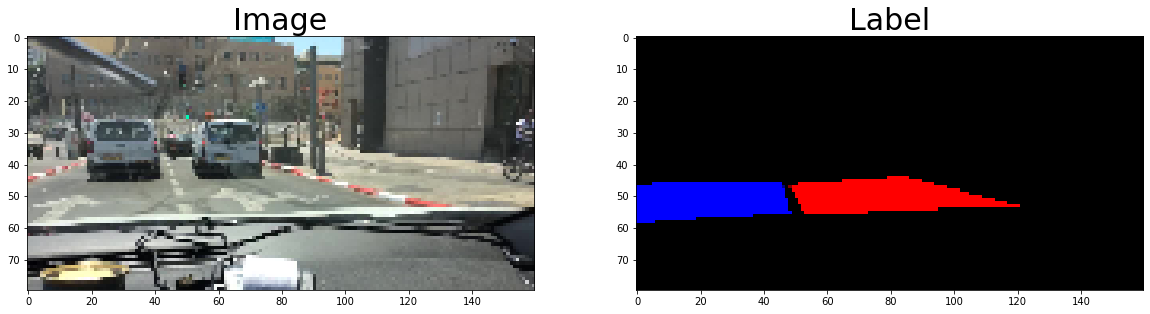

In [ ]:
import random
index = random.randint(0,len(labels))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(images[index].squeeze())
ax1.set_title('Image', fontsize=30)
ax2.imshow(labels[index].squeeze())
ax2.set_title('Label', fontsize=30)

In [ ]:
print("There are "+ str(len(images))+ " images and "+ str(len(labels)) +" labels in the dataset")
print("Shape of an image")
print(images[0].shape)
print("Shape of a Label")
print(labels[0].shape)
print("Images range from "+str(np.amin(images[0]))+" to "+str(np.amax(images[0])))
print("Labels range from "+str(np.amin(labels[0]))+" to "+str(np.amax(labels[0])))

There are 3000 images and 3000 labels in the dataset
Shape of an image
(80, 160, 3)
Shape of a Label
(80, 160, 3)
Images range from 0 to 255
Labels range from 0.0 to 1.0


## Labels & Output


To fit an Encoder-Decoder Neural Network; you will need to preprocess your labels. Currently, **your labels are RGB images of dimension 160x80x3.**

As you can see here, we have multiple options, and I will detail all 3 of them.<p>
![Texte alternatif…](http://ronny.rest/media/tutorials/segmentation/ZZZ_IMAGES_DIR/label_formats.jpeg)


*   **A- Class Labels**
Each Pixel is a number representing a class.<p>
In this case, the output is simply a matrix of 1 channel with these numbers.
*   **B- RGB Mappings**
This is what we currently have, the labels are in RGB format.<p>
As we are only working with 2 classes, and they all are colored either red or blue, it's quite easy to work with.
If you ever get more classes, let's say 7, some pixels will not be 0 or 255, they will have some intensity value and it will get more complicated.
Preprocessing is therefore necessary.
*   **C- One Hot Vectors**
Similar to format A, but one-hot encoded.

**Your Choice**

For this project, you have the choice to detect only the driveable area or the driveable area + the adjacent lanes. <p>

You will therefore
*   Remove every blue pixel and face a 1-channel problem (driveable area detection)
*   Keep the blue pixel, use 3 channels.<p>**One easy solution would be to convert every black pixel into a green one.**
Then, the network would have to label a pixel as either green (background), red (driveable), or blue (adjacent).


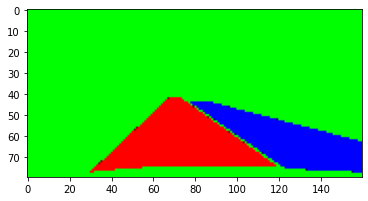

In [ ]:
new_labels = []
for lab in labels:
    for x in range(lab.shape[0]):
        for y in range(lab.shape[1]):
            if (np.all(lab[x][y]==[0,0,0])):
                lab[x][y]=[0,1,0]
    new_labels.append(lab)

plt.imshow(new_labels[0])

**Data Augmentation**

3,000 images can be enough, but in Deep Learning, **more is better**.
If you want a strong model performance, feel free to augment your dataset any way you want.

6000
6000


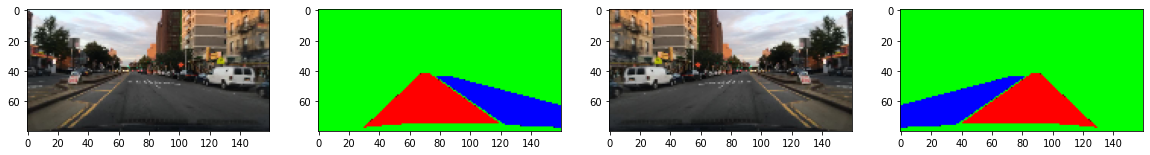

In [ ]:
def flip_image(img):
    return cv2.flip(img, 1)

flipped_images = []
flipped_labels = []

for i in images:
    flipped_images.append(flip_image(i))

for i in labels:
    flipped_labels.append(flip_image(i))

images.extend(flipped_images)
new_labels.extend(flipped_labels)
print(len(images))
print(len(new_labels))

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,10))
ax1.imshow(images[0])
ax2.imshow(new_labels[0])
ax3.imshow(flipped_images[0])
ax4.imshow(flipped_labels[0])

**Train Test Split**<p>
As for every neural network, you will need **training** and **testing** data.

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
images = np.array(images)
labels = np.array(new_labels)

# Shuffle
images, labels = shuffle(images, labels)

# Test size may go from 10% to 30%
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15)
n_train = len(X_train)
n_val = len(X_val)

print("Number of element in training set")
print(n_train)
print("Number of element in validation set")
print(n_val)

Number of element in training set
5100
Number of element in validation set
900


# <a name="Model"></a>2. Create A Deep Learning Model

## Model Definition

Here, we will define a Fully Convolutional Neural Network.<p>
It actually means a **neural networks that doesn't have any Dense layer** (or Fully Connected), but **only Convolutions**.

![Texte alternatif…](https://mi.eng.cam.ac.uk/projects/segnet/images/segnet.png)

We will use **Keras**.<p>
[Here is a way to use Keras for Deep Learning](https://keras.io/getting-started/functional-api-guide/).

**What should we implement?**


1.   Create an **encoder** that learns the features
2.   Create a **decoder** that upsamples to the original image size
3.   Implement advanced techniques such as **1x1 convolutions**, or **skip connections** to make the neural network better.

To avoid overfitting, we can use **Dropout**.
To make the network better, we can use **Batch Normalization** after the input. In semantic segmentation, Batch Normalization have proven amazing results.

Feel free to explore as you build your model.
You can also build a model from existing models.

*   [UNet](https://arxiv.org/pdf/1505.04597.pdf)
*   [SegNet](https://arxiv.org/pdf/1511.00561.pdf)
*   [FCN](https://arxiv.org/pdf/1411.4038.pdf)
*   [DeepLab](https://arxiv.org/pdf/1606.00915.pdf)





**Imports**

In [ ]:
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Activation, Dropout, Conv2D, MaxPooling2D, Reshape, Input, add
from tensorflow.python.keras.layers import UpSampling2D, Conv2DTranspose
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers

**Build your Model**

In [ ]:
def simple_encoder_decoder(input_shape=(80,160,3), pool_size=(2,2)):
    """
    Try a simple Encoder-Decoder architecture.
    Use Convolutions, Transposed Convolutions.
    Use Pooling, Unpooling or UpSampling.
    GOAL: Match the output to the input. Experiment. This is a playground.
    """
    model=Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv2D(8, (5,5), padding='valid', strides=(1,1), activation='relu'))
    model.add(Conv2D(8, (5,5), padding='valid', strides=(1,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(UpSampling2D(size=pool_size))
    model.add(Conv2DTranspose(8, (5,5), padding='valid', strides=(1,1), activation='relu'))
    model.add(Conv2DTranspose(3, (5,5), padding='valid', strides=(1,1), activation='relu'))
    model.summary()

simple_encoder_decoder() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 80, 160, 3)        12        
_________________________________________________________________
conv2d (Conv2D)              (None, 76, 156, 8)        608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 152, 8)        1608      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 76, 8)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 72, 152, 8)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 76, 156, 8)        1608      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 80, 160, 3)        6

In [ ]:
def other_model_dropout(pool_size=(2,2), input_shape=(80,160,3)):
    input_x = Input(shape=(80,160,3))
    x = BatchNormalization(input_shape=input_shape)(input_x)
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x1 = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=pool_size)(x1)
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x2 = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=pool_size)(x2)
    x = Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x3 = Dropout(0.2)(x)
    x = add([x3, x])
    x = MaxPooling2D(pool_size=pool_size)(x3)
    x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = add([x2, x])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(3, (1,1), padding='valid', strides=(1,1), activation='softmax')(x)
    return Model(input_x,x)
model = other_model_dropout()
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 80, 160, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_219 (BatchN (None, 80, 160, 3)   12          input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 78, 158, 32)  896         batch_normalization_219[0][0]    
__________________________________________________________________________________________________
batch_normalization_220 (BatchN (None, 78, 158, 32)  128         conv2d_116[0][0]                 
____________________________________________________________________________________________

In [ ]:
def other_model(pool_size=(2,2), input_shape=(80,160,3)):
    input_x = Input(shape=(80,160,3))
    x = BatchNormalization(input_shape=input_shape)(input_x)
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x1 = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=pool_size)(x1)
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x2 = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=pool_size)(x2)
    x = Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(3, (1,1), padding='valid', strides=(1,1), activation='softmax')(x)
    return Model(input_x,x)
model = other_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 160, 3)]      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 160, 3)        12        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 78, 158, 32)       896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 78, 158, 32)       128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 76, 156, 32)       9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 76, 156, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 78, 32)        0     

In [ ]:
def encoder_decoder_skip_connections(input_shape= (160,80,3), pool_size=(2,2), dropout_rate=0.5):
    """
    Here, build your killer segmentation network.
    Use any technique that can be useful.
    Credits for the architecture: https://towardsdatascience.com/lane-detection-with-deep-learning-part-2-3ba559b5c5af
    """
    # ENCODER
    input_x = Input(shape=(80,160,3))
    x1 = BatchNormalization(input_shape=input_shape)(input_x)
    ## CONV 1
    x = Conv2D(8, (3, 3), strides = (1,1), activation='relu', padding='valid')(x1)
    ## CONV 2 + SKIP CONNECTION
    x = Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    ## CONV 3
    x = Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    ## CONV4 + SKIP CONNECTION
    x2 = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x2)
    ## CONV5
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    ## CONV6
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)
    ## CONV7
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    # DECODER
    ## UPSAMPLING 7
    x = UpSampling2D(size=pool_size, interpolation='nearest')(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 6
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 5
    x = UpSampling2D(size=pool_size, interpolation='nearest')(x)
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)

    ## UPSAMPLING 4
    x = add([x2, x])
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 3
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 2
    x = UpSampling2D(size=pool_size, interpolation='nearest')(x)
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)

    ## UPSAMPLING 1
    x = Conv2DTranspose(3, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = add([x1, x])
    x = Conv2D(3, (1,1), padding=('valid'), strides=(1,1), activation='softmax')(x)
    return Model(input_x,x)
model = encoder_decoder_skip_connections()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 160, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 80, 160, 3)   12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 78, 158, 8)   224         batch_normalization_16[0][0]     
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 76, 156, 16)  1168        conv2d_9[0][0]                   
____________________________________________________________________________________________

## MODEL TRAINING

Use any technique you know to improve model training or generalization.


*   If you want to detect **1 class (driveable area)**, you can use **binary cross-entropy or mean squared error** as a metric.
*  If you want to detect **2 or more classes** (driveable area + adjacent), you can use **categorical cross-entropy** as a metric. <p>

You are free to use any optimizer you want.

**Hyperparameters**

In [ ]:
batch_size = 32
epochs = 10
pool_size = (2, 2)
learning_rate= 0.001
steps_per_epoch=len(X_train)/batch_size
input_shape = X_train.shape[1:]

**Training**

In [ ]:
# Using a generator to help the model use less data
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

# Compiling and training the model
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=learning_rate, amsgrad=False, name="Adam"), loss='categorical_crossentropy')
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=steps_per_epoch, 
          epochs=epochs, verbose=1, validation_data=(X_val, y_val))


# Save model architecture and weights
#model.save('model.h5')

Epoch 1/10
159/159 [==============================] - 7s 33ms/step - loss: 0.2259 - val_loss: 0.2137
Epoch 2/10
159/159 [==============================] - 5s 30ms/step - loss: 0.2212 - val_loss: 0.2113
Epoch 3/10
159/159 [==============================] - 5s 30ms/step - loss: 0.2187 - val_loss: 0.2075
Epoch 4/10
159/159 [==============================] - 5s 30ms/step - loss: 0.2158 - val_loss: 0.2097
Epoch 5/10
159/159 [==============================] - 5s 30ms/step - loss: 0.2131 - val_loss: 0.2043
Epoch 6/10
159/159 [==============================] - 5s 30ms/step - loss: 0.2085 - val_loss: 0.2042
Epoch 7/10
159/159 [==============================] - 5s 30ms/step - loss: 0.2058 - val_loss: 0.1994
Epoch 8/10
159/159 [==============================] - 5s 30ms/step - loss: 0.2062 - val_loss: 0.2024
Epoch 9/10
159/159 [==============================] - 5s 30ms/step - loss: 0.2014 - val_loss: 0.1972
Epoch 10/10
159/159 [==============================] - 5s 30ms/step - loss: 0.2025 - val_lo

**Plot Training Results**

dict_keys(['loss', 'val_loss'])


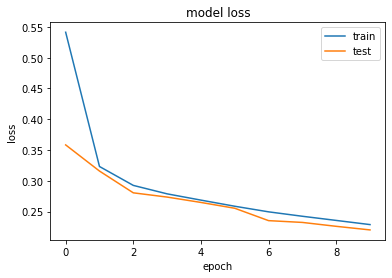

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Test the model and Build a general pipeline

In [ ]:
def rgb_channel(img, thresholding=False, thresh=230):
    """Threshold the re-drawn images"""
    image = np.copy(img)
    if thresholding:
        ret, image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    return R,G,B

**Build the Run Function**
The run function must:
* Take an image as input
* Resize the input to match the model size
* Call model.predict()
* Extract R,G,B channels from prediction
* Rescale to the original image size
* Draw on the input image
* Return the result

In [ ]:
def run(input_image):
    h,w,d = input_image.shape
    network_image = input_image.copy()
    network_image = cv2.resize(network_image, (160,80), interpolation=cv2.INTER_AREA)
    network_image = network_image[None,:,:,:]
    prediction = model.predict(network_image)[0]*255
    R,G,B = rgb_channel(prediction)
    blank = np.zeros_like(R).astype(np.uint8)
    lane_image = np.dstack((R,blank, B))
    lane_image = cv2.resize(lane_image, (w,h))
    result = cv2.addWeighted(input_image, 1, lane_image.astype(np.uint8), 1, 0)
    return result

**Test from the Dataset**

Text(0.5, 1.0, 'Drawn Prediction')

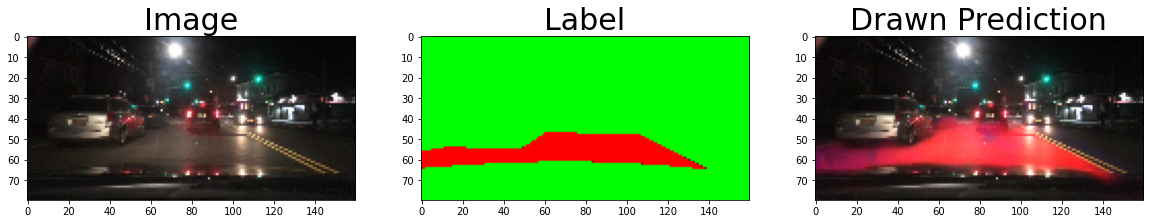

In [ ]:
index = random.randint(0,len(images))

img_test = run(images[index])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(images[index].squeeze())
ax1.set_title('Image', fontsize=30)
ax2.imshow(labels[index].squeeze())
ax2.set_title('Label', fontsize=30)
ax3.imshow(img_test)
ax3.set_title("Drawn Prediction", fontsize=30)

**Test on a never seen image**

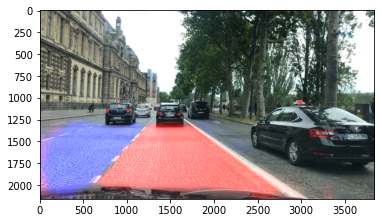

In [ ]:
predict_image = mpimg.imread("../Tracking/Images/image_0.jpg")
plt.imshow(run(predict_image))
plt.show()

# <a name="Video"></a>3. Run on a Video

Here is the best part. FCN models generally are fast. They can run on CPU at 5 FPS and on GPU at a very high frame rate.<p>
Test your code on a video and see how it worked.

In [ ]:
import glob
img_array = []
for filename in sorted(glob.glob('data_2/*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
out = cv2.VideoWriter('videos/project_2.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
from moviepy.editor import VideoFileClip

video_file = "/content/drive/My Drive/One Step Ahead/SDC Course/Drivable Area Detection/videos/costa_rica_challenge.mp4"
clip = VideoFileClip(video_file)
white_clip = clip.fl_image(run)
%time white_clip.write_videofile("output/test_project_costarica.mp4",audio=False)

[MoviePy] >>>> Building video output/test_project_costarica.mp4
[MoviePy] Writing video output/test_project_costarica.mp4


100%|█████████▉| 1839/1840 [05:03<00:00,  6.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/test_project_costarica.mp4 

CPU times: user 2min 54s, sys: 12.4 s, total: 3min 6s
Wall time: 5min 9s


**Costa Rica Challenge**<p>
Try your algorithm on Costa Rica roads!
Use the files **costa_rica_challenge** and **costa_rica_challenge_2** provided.<P>
/!\ video was taken from an iPhone X at 60 FPS and 4K resolution...

In [ ]:
## VIDEO IS TAKEN AT 60 FPS ON 4K RESOLUTION; NO IMAGE DISTORTION CORRECTION IS DONE
## THE PROGRAM HERE RUNS ON CPU AT 2 FPS; RUN ON YOUR OWN MACHINE FOR BETTER PERFORMANCE